## Data Preparation 

We use Beeline benchmark to benchmark the performance of DeepSEM.
The data preparation process are shown in below.
1. Download raw data from https://doi.org/10.5281/zenodo.3378975, which is provided by BEELINE benchmark
2. Use the preoprocess code in https://github.com/Murali-group/Beeline/blob/master/generateExpInputs.py to generate dataset.

We also provide demo data as shown in ../demo_data/GRN_inference/input 

# Run DeepSEM by using following command:
for cell type specific GRN inference task: python main.py --task non_celltype_GRN --data_file demo_data/GRN_inference/input/500_STRING_hESC/data.csv --net_file demo_data/GRN_inference/input/500_STRING_hESC/label.csv --setting new --alpha 100 --beta 1 --n_epoch 90 --save_name out


for cell type non-specific GRN inference task: python main.py --task celltype_GRN --data_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/data.csv --net_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out

**Parameters**

- $\alpha$ is the $L^1$ regularization factor
- $\beta$ is the coefficient of the KL divergence loss


In [51]:
# Filter most variable genes in input and output 

from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
path = "../demo_data/GRN_inference/input/500_ChIP-seq_hESC"
input = pd.read_csv(path + "/data.csv", index_col = 0)
keepcols = input.var(0) > 10 #threshold to keep ~ 100 most variable genes
print("Number of genes kept =", keepcols.sum())
input = input[input.columns[keepcols]]
input.to_csv(path + "/data2.csv")

label = pd.read_csv(path + "/label.csv")
count = 0
gene_feats = set(input.columns)
keeprow = label["Gene1"].isin(gene_feats) & label["Gene2"].isin(gene_feats)
label = label[keeprow]
print("Number of ground truth edges =", keeprow.sum())
label.to_csv(path + "/label2.csv")

Number of genes kept = 157
Number of ground truth edges = 108


In [53]:
for i in range(10):
    #!python ../main.py --task non_celltype_GRN --data_file ../demo_data/GRN_inference/input/500_STRING_hESC/data2.csv --net_file ../demo_data/GRN_inference/input/500_STRING_hESC/label2.csv --setting new --inverse 1 --alpha 100 --beta 1 --n_epoch 120 --save_name out/run_{i+1}
    !python ../main.py --task celltype_GRN --data_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/data2.csv --net_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label2.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out_chip/run_{i+1}

Using inverse constraint
dir exist
epoch: 1 Ep: 0 Epr: 0.0 loss: 1.0080857525269191 mse_loss: 1.0064751555522282 kl_loss: 0.00098869351495523 sparse_loss: 0.0006219298035527269
epoch: 2 Ep: 0 Epr: 0.0 loss: 1.0062421560287476 mse_loss: 1.0046303023894627 kl_loss: 0.0009857481782091781 sparse_loss: 0.0006261158996494487
epoch: 4 Ep: 0 Epr: 0.0 loss: 0.9469974637031555 mse_loss: 0.943049485484759 kl_loss: 0.0033469443248274424 sparse_loss: 0.0006010394329981258
epoch: 5 Ep: 0 Epr: 0.0 loss: 0.935461034377416 mse_loss: 0.9315267503261566 kl_loss: 0.003350024422009786 sparse_loss: 0.0005842454896386092
epoch: 7 Ep: 0 Epr: 0.0 loss: 0.4153057932853699 mse_loss: 0.3979424486557643 kl_loss: 0.016808778202782076 sparse_loss: 0.0005545652190145726
epoch: 8 Ep: 0 Epr: 0.0 loss: 0.3982426126797994 mse_loss: 0.38084432234366733 kl_loss: 0.016870463732630014 sparse_loss: 0.0005278264143271372
epoch: 10 Ep: 0 Epr: 0.0 loss: 0.28139257182677585 mse_loss: 0.2558114205797513 kl_loss: 0.0250695040449500

# Calculate EPR values

[1.1851851851851851, 1.1851851851851851, 0.8888888888888888, 1.1851851851851851, 1.037037037037037, 1.037037037037037, 1.037037037037037, 0.8888888888888888, 1.037037037037037, 0.8888888888888888]


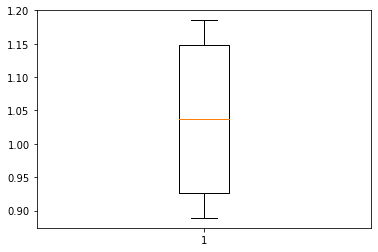

In [38]:
def compute_epr(output, label):
    col1 = "TF"
    col2 = "Target"
    output['EdgeWeight'] = abs(output['EdgeWeight'])
    output = output.sort_values('EdgeWeight',ascending=False)
    
    TFs = set(label['Gene1'])
    Genes = set(label['Gene1'])| set(label['Gene2'])
    output = output[output[col1].apply(lambda x: x in TFs)]
    output = output[output[col2].apply(lambda x: x in Genes)]
    label_set = set(label['Gene1']+'|'+label['Gene2'])
    output = output.iloc[:len(label_set)]
    early_TPs = len(set(output[col1]+'|'+output[col2]) & label_set)
    den = (len(label_set)**2/(len(TFs)*len(Genes)-len(TFs)))
    EP = early_TPs/len(label_set)
    EPR = early_TPs/den
    #print("true positives among top k scored =", early_TPs)
    #print("true positives among top k random scored =", den)
    #print("AUPRC ratio = ", early_TPs / den)
    return EP, EPR 

eprs = []
eps = []
for i in range(1, 11):
    output = pd.read_csv("out/run_{}/GRN_inference_result.tsv".format(i),sep='\t')
    #output = pd.read_csv("/home/jel-khoury/Differentiable-DAG-Sampling/src/notebooks/pred.tsv", sep = '\t')
    ep, epr = compute_epr(output, label)
    eprs.append(epr)
    eps.append(ep)

print(eprs)
plt.boxplot(eprs)

plt.show()
    


# Calculate AUPR ratio values

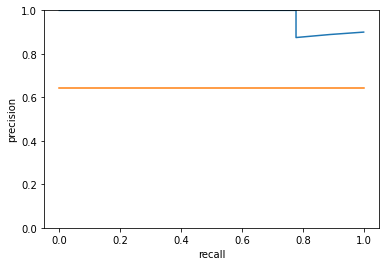

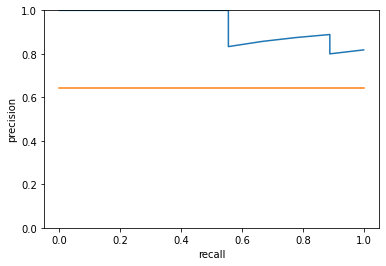

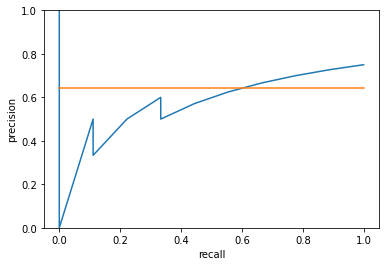

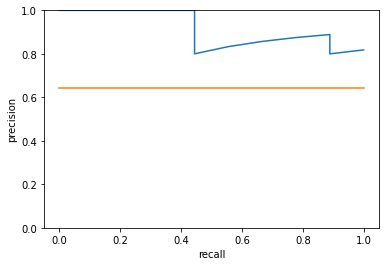

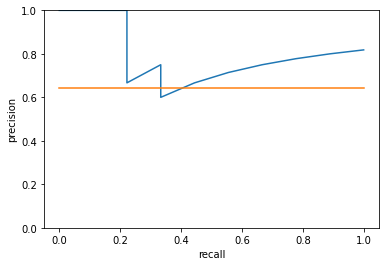

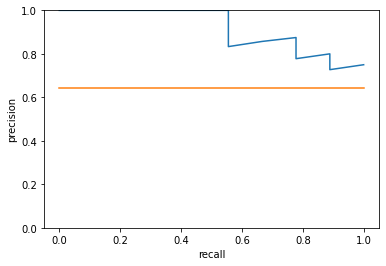

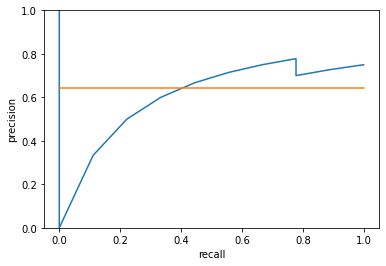

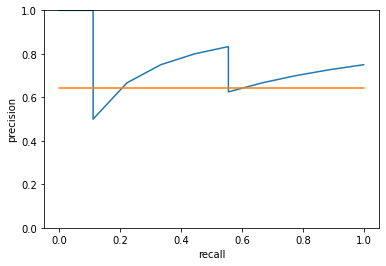

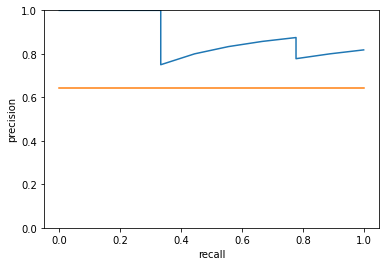

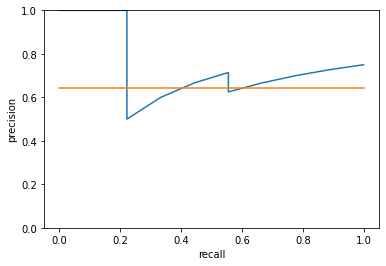

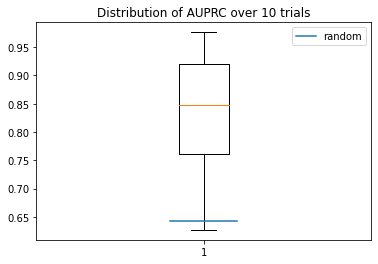

In [39]:
def compute_prc(output, label):
    output['EdgeWeight'] = abs(output['EdgeWeight'])
    output = output.sort_values('EdgeWeight',ascending=False)
    
    TFs = set(label['Gene1'])
    Genes = set(label['Gene1'])| set(label['Gene2'])
    #print("number or target genes in output :", len(output['Target'].unique()))
    #print("number or TFs in output :", len(output['TF'].unique()))
    col1 = "TF"
    col2 = "Target"
    output = output[output[col1].apply(lambda x: x in TFs)]
    output = output[output[col2].apply(lambda x: x in Genes)]
    label_set = set(label['Gene1']+'|'+label['Gene2'])
    res_d = {}
    l = []
    p= []
    for item in (output.to_dict('records')):
            res_d[item[col1] + '|' + item[col2]] = item['EdgeWeight']
    for item in (set(label['Gene1'])):
            for item2 in  set(label['Gene1'])| set(label['Gene2']):
                if item+ '|' + item2 in label_set:
                    l.append(1)
                else:
                    l.append(0)
                if item + '|' + item2 in res_d:
                    p.append(res_d[item + '|' + item2])
                else:
                    p.append(-1)
    score = average_precision_score(l,p)
    precision, recall, thresholds = precision_recall_curve(l, p)
    random_score = len(label)/len(TFs)/len(Genes)
    return precision, recall, score, random_score


label = pd.read_csv('../demo_data/GRN_inference/input/500_STRING_hESC/label2.csv', index_col = 0)
#label = pd.read_csv("../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv")

scores = []
for i in range(1, 11):
    #output = pd.read_csv("/home/jel-khoury/Differentiable-DAG-Sampling/src/notebooks/pred.tsv", sep = '\t', index_col = 0)
    output = pd.read_csv("out/run_{}/GRN_inference_result.tsv".format(i),sep='\t')
    precision, recall, score, rd_score = compute_prc(output, label)
    plt.plot(recall, precision)
    plt.plot(recall, rd_score*np.ones_like(recall))
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.ylim(0, 1)
    plt.show()
    scores.append(score)

plt.boxplot(scores)
plt.plot([0.9, 1.1], [rd_score, rd_score], label = 'random')
plt.title("Distribution of AUPRC over 10 trials")
plt.legend()
plt.show()

# Ensemble DeepSEM result

In [40]:
res = []
for i in range(10):
    res.append(pd.read_csv("out/run_{}/GRN_inference_result.tsv".format(i+1),sep='\t'))
res = pd.concat(res)
res['EdgeWeight'] = abs(res['EdgeWeight'])
group = res.groupby(['TF','Target']).mean()
group = group.sort_values('EdgeWeight',ascending=False)
group = group.iloc[:len(label)]

In [46]:
TFs = set(label['Gene1'])
Genes = set(label['Gene1'])| set(label['Gene2'])
output = pd.read_csv("out/run_1/GRN_inference_result.tsv",sep='\t')
output = output[output['TF'].apply(lambda x: x in TFs)]
output = output[output['Target'].apply(lambda x: x in Genes)]
Gt = nx.DiGraph()
#Gt.add_nodes_from(TFs)
#Gt.add_nodes_from(Genes)
Gt.add_edges_from([tuple(label.iloc[i]) for i in range(len(label))])

Gp = nx.DiGraph()
output = output.sort_values('EdgeWeight', ascending=False)
output = output[:len(label)]

Gp.add_weighted_edges_from([tuple(output.iloc[i]) for i in range(len(output))])

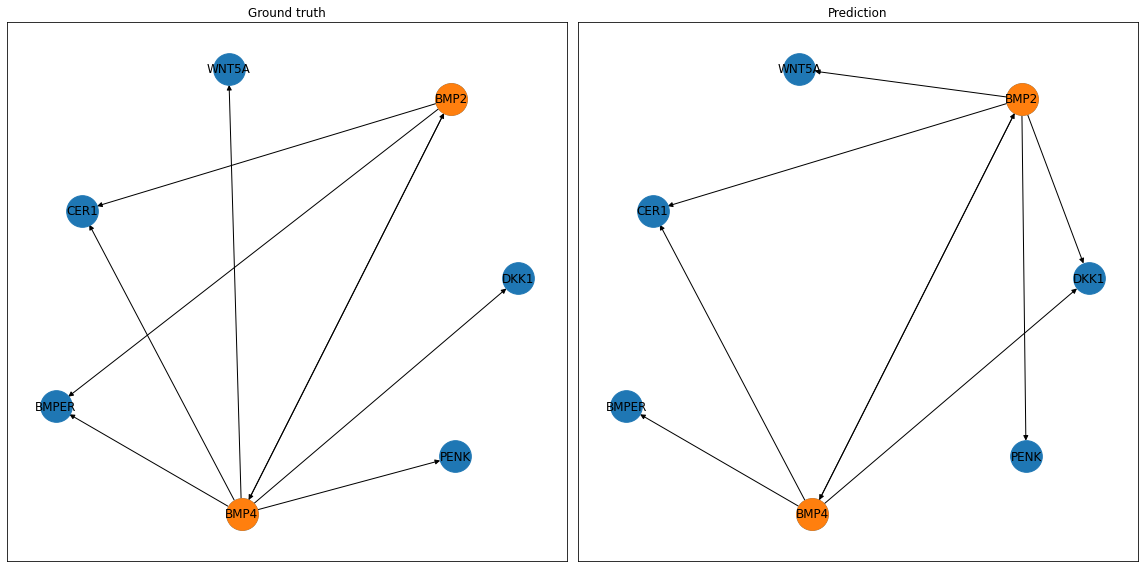

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
allnodes = list(Gt.nodes) + list(Gp.nodes)
pos = nx.spring_layout(allnodes)  # positions for all nodes
options = {'node_size': 1000, 'alpha': 1}
nx.draw_networkx_nodes(Gp, pos, nodelist=set(output['Target']), node_color='tab:blue', ax = ax[1], **options)
nx.draw_networkx_nodes(Gp, pos, nodelist=set(output['TF']), node_color='tab:orange', ax = ax[1], **options)
nx.draw_networkx_edges(Gp,pos, ax = ax[1], **options)
nx.draw_networkx_labels(Gp, pos, ax = ax[1])
ax[1].set_title("Prediction")

nx.draw_networkx_nodes(Gt, pos, nodelist=Genes, node_color='tab:blue', ax = ax[0], **options)
nx.draw_networkx_nodes(Gt, pos, nodelist=TFs & Gt.nodes, node_color='tab:orange', ax = ax[0], **options)
nx.draw_networkx_edges(Gt, pos, ax = ax[0], **options)
nx.draw_networkx_labels(Gt, pos, ax=ax[0])
ax[0].set_title("Ground truth")
plt.tight_layout()

plt.show()

In [48]:
Gt.edges & Gp.edges

{('BMP2', 'BMP4'),
 ('BMP2', 'CER1'),
 ('BMP4', 'BMP2'),
 ('BMP4', 'BMPER'),
 ('BMP4', 'CER1'),
 ('BMP4', 'DKK1')}